In [1]:
import gym
import numpy as np
import torch
from sac_agent import soft_actor_critic_agent
from replay_memory import ReplayMemory

seed=0  
env = gym.make('BipedalWalker-v2')
torch.manual_seed(seed)
np.random.seed(seed)
env.seed(seed)
max_steps = env._max_episode_steps
print('max_steps: ', max_steps)

batch_size=256

LEARNING_RATE=0.0005 # lr = 0.0001 for BipedalWalker-SAC
eval=True  ## 
start_steps=10000 ## Steps sampling random actions
replay_size=1000000 ## size of replay buffer
updates_per_step=4
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# alpha=0.2  # relative importance of the entropy
# gamma=0.99  # discount factor 
# tau=0.005  # target smoothing coefficient(τ)

agent = soft_actor_critic_agent(env.observation_space.shape[0], env.action_space, \
        device=device, hidden_size=256, lr=LEARNING_RATE, gamma=0.99, tau=0.005, alpha=0.2)

memory = ReplayMemory(replay_size)

print('device: ', device)
print('state dim: ', env.observation_space.shape[0])
print('action dim: ', env.action_space)
print('leraning rate: ', LEARNING_RATE)
print('updates_per_step: ', updates_per_step)

max_steps:  1600
device:  cuda:0
state dim:  24
action dim:  Box(4,)
leraning rate:  0.0005
updates_per_step:  4


In [2]:
def save(agent, directory, filename, suffix):
    torch.save(agent.policy.state_dict(), '%s/%s_actor_%s.pth' % (directory, filename, suffix))
    torch.save(agent.critic.state_dict(), '%s/%s_critic_%s.pth' % (directory, filename, suffix))

In [3]:
import time
from  collections  import deque

def sac_train(max_steps):

    total_numsteps = 0
    updates = 0
    num_episodes = 10001
    updates=0

    time_start = time.time()
    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = [] 
    
    for i_episode in range(num_episodes): 
        episode_reward = 0
        episode_steps = 0
        done = False
        state = env.reset()

        for step in range(max_steps):    
            if start_steps > total_numsteps:
                action = env.action_space.sample()  # Sample random action
            else:
                action = agent.select_action(state)  # Sample action from policy

            if len(memory) > batch_size:
                
                # Update parameters of all the networks
                agent.update_parameters(memory, batch_size, updates)

                updates += 1

            next_state, reward, done, _ = env.step(action) # Step
            episode_steps += 1
            total_numsteps += 1
            episode_reward += reward

            mask = 1 if episode_steps == env._max_episode_steps else float(not done)

            memory.push(state, action, reward, next_state, mask) # Append transition to memory

            state = next_state
            
            if done:
                break

        scores_deque.append(episode_reward)
        scores_array.append(episode_reward)        
        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)
        
        if i_episode % 20 == 0 and i_episode > 0:
            save(agent, 'dir_chk_lr0005', 'weights', str(i_episode))

        s =  (int)(time.time() - time_start)
            
        print("Ep.: {}, Total Steps: {}, Ep.Steps: {}, Score: {:.2f}, Avg.Score: {:.2f}, Time: {:02}:{:02}:{:02}".\
            format(i_episode, total_numsteps, episode_steps, episode_reward, avg_score, \
                  s//3600, s%3600//60, s%60))

                    
        if (avg_score > 300.5):
            print('Solved environment with Avg Score:  ', avg_score)
            break;
            
    return scores_array, avg_scores_array 

scores, avg_scores = sac_train(max_steps=max_steps)

Ep.: 0, Total Steps: 90, Ep.Steps: 90, Score: -98.13, Avg.Score: -98.13, Time: 00:00:00
Ep.: 1, Total Steps: 151, Ep.Steps: 61, Score: -114.96, Avg.Score: -106.55, Time: 00:00:00
Ep.: 2, Total Steps: 229, Ep.Steps: 78, Score: -100.64, Avg.Score: -104.58, Time: 00:00:00
Ep.: 3, Total Steps: 1829, Ep.Steps: 1600, Score: -87.41, Avg.Score: -100.29, Time: 00:01:16
Ep.: 4, Total Steps: 1875, Ep.Steps: 46, Score: -112.80, Avg.Score: -102.79, Time: 00:01:18
Ep.: 5, Total Steps: 3475, Ep.Steps: 1600, Score: -88.98, Avg.Score: -100.49, Time: 00:02:30
Ep.: 6, Total Steps: 3518, Ep.Steps: 43, Score: -107.26, Avg.Score: -101.46, Time: 00:02:32
Ep.: 7, Total Steps: 3581, Ep.Steps: 63, Score: -107.01, Avg.Score: -102.15, Time: 00:02:35
Ep.: 8, Total Steps: 3650, Ep.Steps: 69, Score: -99.62, Avg.Score: -101.87, Time: 00:02:38
Ep.: 9, Total Steps: 5250, Ep.Steps: 1600, Score: -77.31, Avg.Score: -99.41, Time: 00:03:51
Ep.: 10, Total Steps: 5333, Ep.Steps: 83, Score: -100.14, Avg.Score: -99.48, Time: 00

Ep.: 88, Total Steps: 16028, Ep.Steps: 59, Score: -103.86, Avg.Score: -103.59, Time: 00:12:23
Ep.: 89, Total Steps: 16086, Ep.Steps: 58, Score: -103.41, Avg.Score: -103.59, Time: 00:12:26
Ep.: 90, Total Steps: 16161, Ep.Steps: 75, Score: -103.59, Avg.Score: -103.59, Time: 00:12:30
Ep.: 91, Total Steps: 16228, Ep.Steps: 67, Score: -103.46, Avg.Score: -103.58, Time: 00:12:34
Ep.: 92, Total Steps: 16315, Ep.Steps: 87, Score: -102.36, Avg.Score: -103.57, Time: 00:12:38
Ep.: 93, Total Steps: 16378, Ep.Steps: 63, Score: -102.61, Avg.Score: -103.56, Time: 00:12:42
Ep.: 94, Total Steps: 16465, Ep.Steps: 87, Score: -99.48, Avg.Score: -103.52, Time: 00:12:46
Ep.: 95, Total Steps: 16522, Ep.Steps: 57, Score: -103.48, Avg.Score: -103.52, Time: 00:12:49
Ep.: 96, Total Steps: 16583, Ep.Steps: 61, Score: -99.72, Avg.Score: -103.48, Time: 00:12:52
Ep.: 97, Total Steps: 16663, Ep.Steps: 80, Score: -98.91, Avg.Score: -103.43, Time: 00:12:56
Ep.: 98, Total Steps: 16723, Ep.Steps: 60, Score: -102.68, Avg.

Ep.: 175, Total Steps: 26385, Ep.Steps: 92, Score: -125.06, Avg.Score: -104.46, Time: 00:21:49
Ep.: 176, Total Steps: 26427, Ep.Steps: 42, Score: -114.65, Avg.Score: -104.59, Time: 00:21:51
Ep.: 177, Total Steps: 28027, Ep.Steps: 1600, Score: -122.14, Avg.Score: -104.76, Time: 00:23:16
Ep.: 178, Total Steps: 29627, Ep.Steps: 1600, Score: -108.91, Avg.Score: -104.82, Time: 00:24:36
Ep.: 179, Total Steps: 29709, Ep.Steps: 82, Score: -115.83, Avg.Score: -104.95, Time: 00:24:40
Ep.: 180, Total Steps: 31309, Ep.Steps: 1600, Score: -112.30, Avg.Score: -105.02, Time: 00:26:02
Ep.: 181, Total Steps: 32909, Ep.Steps: 1600, Score: -101.63, Avg.Score: -105.00, Time: 00:27:23
Ep.: 182, Total Steps: 34509, Ep.Steps: 1600, Score: -101.16, Avg.Score: -104.97, Time: 00:28:46
Ep.: 183, Total Steps: 34611, Ep.Steps: 102, Score: -113.91, Avg.Score: -105.06, Time: 00:28:51
Ep.: 184, Total Steps: 34691, Ep.Steps: 80, Score: -117.59, Avg.Score: -105.20, Time: 00:28:55
Ep.: 185, Total Steps: 36291, Ep.Steps:

Ep.: 261, Total Steps: 70160, Ep.Steps: 1600, Score: -16.02, Avg.Score: -98.33, Time: 00:59:51
Ep.: 262, Total Steps: 71760, Ep.Steps: 1600, Score: -116.96, Avg.Score: -98.48, Time: 01:01:15
Ep.: 263, Total Steps: 73360, Ep.Steps: 1600, Score: -79.51, Avg.Score: -98.29, Time: 01:02:37
Ep.: 264, Total Steps: 74960, Ep.Steps: 1600, Score: -57.48, Avg.Score: -97.88, Time: 01:04:00
Ep.: 265, Total Steps: 76560, Ep.Steps: 1600, Score: -44.33, Avg.Score: -97.31, Time: 01:05:23
Ep.: 266, Total Steps: 78160, Ep.Steps: 1600, Score: -39.95, Avg.Score: -96.50, Time: 01:06:55
Ep.: 267, Total Steps: 79424, Ep.Steps: 1264, Score: -84.74, Avg.Score: -96.30, Time: 01:08:04
Ep.: 268, Total Steps: 81024, Ep.Steps: 1600, Score: 16.84, Avg.Score: -95.11, Time: 01:09:29
Ep.: 269, Total Steps: 81710, Ep.Steps: 686, Score: -83.14, Avg.Score: -94.90, Time: 01:10:05
Ep.: 270, Total Steps: 82004, Ep.Steps: 294, Score: -84.67, Avg.Score: -94.69, Time: 01:10:20
Ep.: 271, Total Steps: 82361, Ep.Steps: 357, Score: 

Ep.: 348, Total Steps: 155556, Ep.Steps: 1146, Score: 297.12, Avg.Score: 64.24, Time: 02:15:43
Ep.: 349, Total Steps: 156694, Ep.Steps: 1138, Score: 296.60, Avg.Score: 68.15, Time: 02:16:43
Ep.: 350, Total Steps: 157842, Ep.Steps: 1148, Score: 296.71, Avg.Score: 72.06, Time: 02:17:43
Ep.: 351, Total Steps: 158888, Ep.Steps: 1046, Score: 301.81, Avg.Score: 76.16, Time: 02:18:38
Ep.: 352, Total Steps: 159920, Ep.Steps: 1032, Score: 302.02, Avg.Score: 79.86, Time: 02:19:33
Ep.: 353, Total Steps: 161024, Ep.Steps: 1104, Score: 297.86, Avg.Score: 83.62, Time: 02:20:31
Ep.: 354, Total Steps: 162081, Ep.Steps: 1057, Score: 301.52, Avg.Score: 87.48, Time: 02:21:27
Ep.: 355, Total Steps: 163173, Ep.Steps: 1092, Score: 298.22, Avg.Score: 91.27, Time: 02:22:24
Ep.: 356, Total Steps: 163859, Ep.Steps: 686, Score: 79.78, Avg.Score: 92.73, Time: 02:23:01
Ep.: 357, Total Steps: 164907, Ep.Steps: 1048, Score: 301.53, Avg.Score: 96.37, Time: 02:23:56
Ep.: 358, Total Steps: 165953, Ep.Steps: 1046, Score

Ep.: 435, Total Steps: 234532, Ep.Steps: 969, Score: 305.93, Avg.Score: 256.75, Time: 03:25:40
Ep.: 436, Total Steps: 235503, Ep.Steps: 971, Score: 301.91, Avg.Score: 256.82, Time: 03:26:32
Ep.: 437, Total Steps: 235568, Ep.Steps: 65, Score: -112.04, Avg.Score: 254.04, Time: 03:26:36
Ep.: 438, Total Steps: 236573, Ep.Steps: 1005, Score: 304.96, Avg.Score: 256.02, Time: 03:27:30
Ep.: 439, Total Steps: 236925, Ep.Steps: 352, Score: 6.82, Avg.Score: 253.17, Time: 03:27:49
Ep.: 440, Total Steps: 237854, Ep.Steps: 929, Score: 308.97, Avg.Score: 253.39, Time: 03:28:39
Ep.: 441, Total Steps: 238818, Ep.Steps: 964, Score: 305.04, Avg.Score: 256.85, Time: 03:29:31
Ep.: 442, Total Steps: 239724, Ep.Steps: 906, Score: 177.16, Avg.Score: 255.66, Time: 03:30:20
Ep.: 443, Total Steps: 240671, Ep.Steps: 947, Score: 308.66, Avg.Score: 255.79, Time: 03:31:11
Ep.: 444, Total Steps: 241605, Ep.Steps: 934, Score: 309.11, Avg.Score: 255.96, Time: 03:32:02
Ep.: 445, Total Steps: 242533, Ep.Steps: 928, Score

Ep.: 522, Total Steps: 306427, Ep.Steps: 250, Score: -24.15, Avg.Score: 288.29, Time: 04:28:37
Ep.: 523, Total Steps: 307247, Ep.Steps: 820, Score: 314.58, Avg.Score: 288.36, Time: 04:29:20
Ep.: 524, Total Steps: 308084, Ep.Steps: 837, Score: 313.28, Avg.Score: 288.41, Time: 04:30:04
Ep.: 525, Total Steps: 308911, Ep.Steps: 827, Score: 314.60, Avg.Score: 292.45, Time: 04:30:47
Ep.: 526, Total Steps: 309743, Ep.Steps: 832, Score: 314.31, Avg.Score: 292.50, Time: 04:31:30
Ep.: 527, Total Steps: 310582, Ep.Steps: 839, Score: 316.50, Avg.Score: 292.58, Time: 04:32:14
Ep.: 528, Total Steps: 311438, Ep.Steps: 856, Score: 314.36, Avg.Score: 292.63, Time: 04:32:58
Ep.: 529, Total Steps: 312282, Ep.Steps: 844, Score: 315.17, Avg.Score: 292.69, Time: 04:33:42
Ep.: 530, Total Steps: 313122, Ep.Steps: 840, Score: 315.30, Avg.Score: 292.78, Time: 04:34:26
Ep.: 531, Total Steps: 313956, Ep.Steps: 834, Score: 314.62, Avg.Score: 292.86, Time: 04:35:09
Ep.: 532, Total Steps: 314831, Ep.Steps: 875, Scor

In [4]:
save(agent, 'dir_chk_lr0005', 'weights', 'final')

length of scores:  540 , len of avg_scores:  540


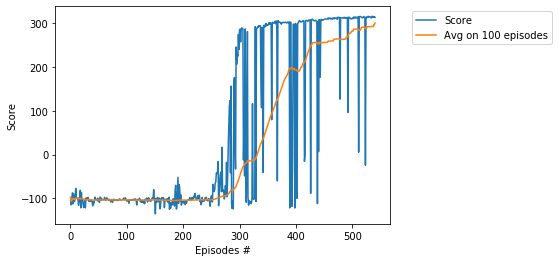

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

In [6]:
def play(env, agent, num_episodes):
    
    state = env.reset()
    scores_deque = deque(maxlen=100)
    scores = []
    
    for i_episode in range(num_episodes + 1):
        
        state = env.reset()
        score = 0                    
        time_start = time.time()
        
        while True:
            
            action = agent.select_action(state, eval=True)
            env.render()
            next_state, reward, done, _ = env.step(action)
            score += reward 
            state = next_state
    
            if done:
                break
                
        s = (int)(time.time() - time_start)
        
        scores_deque.append(score)
        scores.append(score)    
        
        print('Episode {}\tAverage Score: {:.2f},\tScore: {:.2f} \tTime: {:02}:{:02}:{:02}'\
                  .format(i_episode, np.mean(scores_deque), score, s//3600, s%3600//60, s%60)) 
    

In [7]:
play(env=env, agent=agent, num_episodes=5)

Episode 0	Average Score: 318.53,	Score: 318.53 	Time: 00:00:16
Episode 1	Average Score: 318.56,	Score: 318.59 	Time: 00:00:13
Episode 2	Average Score: 318.68,	Score: 318.92 	Time: 00:00:14
Episode 3	Average Score: 318.59,	Score: 318.35 	Time: 00:00:14
Episode 4	Average Score: 318.50,	Score: 318.10 	Time: 00:00:14
Episode 5	Average Score: 318.36,	Score: 317.66 	Time: 00:00:14


In [8]:
env.close()